In [1]:

from dwdweather import DwdWeather
from datetime import datetime

# create client
dw = DwdWeather()

# Find closest station to position
closest = dw.nearest_station(lon=7, lat=51)

# The hour you're interested in.
# The example is 2014-03-22 12:00 (UTC).
query_hour = datetime(2014, 3, 22, 12)

result = dw.query(station_id=closest["station_id"], hour=query_hour)


ModuleNotFoundError: No module named 'dwdweather'

In [28]:
import pandas as pd
import matplotlib.pyplot as plt

In [17]:
measurement = pd.read_csv("../../windmeasurement.csv") 
forecast = pd.read_csv("../../windforecast.csv") 

In [18]:
measurement.head()

,runtime,wind_average,wind_max,wind_angle
0,2018-12-11 18:07:00+00:00,1.940,3.686,NaN
1,2018-12-11 17:52:00+00:00,0.388,1.746,NaN
2,2018-12-11 17:37:00+00:00,0.000,0.000,NaN
3,2018-12-11 17:22:00+00:00,0.000,0.000,NaN
4,2018-12-11 17:07:00+00:00,0.000,0.970,NaN


In [24]:
measurement['runtime'] = pd.to_datetime(measurement['runtime'])
forecast['forecast_time'] = pd.to_datetime(forecast['forecast_time'])
forecast['runtime'] = pd.to_datetime(forecast['runtime'])

## Measurement data

/home/magnus/anaconda3/lib/python3.6/site-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


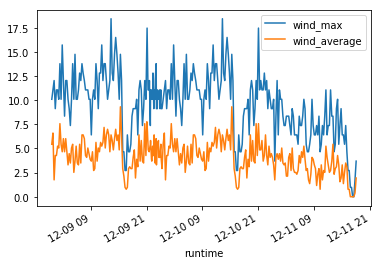

In [34]:
fig, ax = plt.subplots()
measurement.plot(ax = ax, x = 'runtime', y = ['wind_max', 'wind_average']);
#forecast.plot(ax = ax, x = 'forecast_time', y = 'wind_max');



##

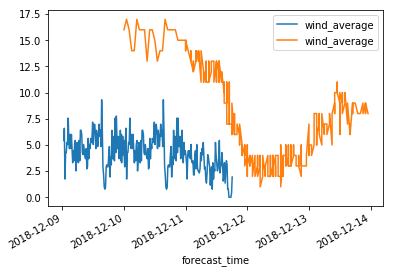

In [31]:
fig, ax = plt.subplots()
measurement.plot(ax = ax, x = 'runtime', y = 'wind_average');
forecast.plot(ax = ax, x = 'forecast_time', y = 'wind_average');